In [1]:
# This script is powered by pyOpenMS, an open-source Python library for mass spectrometry. 
# For further documentation, please see https://pyopenms.readthedocs.io
# Röst HL, Schmitt U, Aebersold R, Malmström L. pyOpenMS: a Python-based interface to the OpenMS mass-spectrometry algorithm library. Proteomics. 2014 Jan;14(1):74-7. doi: 10.1002/pmic.201300246.

In [2]:
import matplotlib.pyplot as plt
import pyopenms as oms
import pandas as pd
import csv
import os
from pyopenms import MSExperiment, MzMLFile
from pyopenms.plotting import plot_spectrum, mirror_plot_spectrum
from tabulate import tabulate
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from pathlib import Path


In [3]:
from itertools import product

def generate_combinations(peptides, length):
    return [''.join(p) for p in product(peptides, repeat=length)]

# Example using WR, WD, WN as starting building block for combinatorial peptide sequnence creation
peptides = ["WR", "WD", "WN"]
length = 2  # Adjust this to change the length of combinatorial repetitions
List_Of_Peptides = peptides + generate_combinations(peptides, length)

# Print the list of combinations including the starting building blocks
print(List_Of_Peptides)

['WR', 'WD', 'WN', 'WRWR', 'WRWD', 'WRWN', 'WDWR', 'WDWD', 'WDWN', 'WNWR', 'WNWD', 'WNWN']


In [4]:
# Set intensity threshold and create FASTA file using the List of Peptides

MW_toleranz = 0.01
Int_threshold = 10000.0

entries = []

for i in range(len(List_Of_Peptides)):    
    tmp = oms.FASTAEntry()  # one entry in a FASTA file
    tmp.sequence = List_Of_Peptides[i]
    tmp.description = List_Of_Peptides[i]
    tmp.identifier = List_Of_Peptides[i]
    entries.append(tmp)

f = oms.FASTAFile()
f.store("peptides.fasta", entries)

print(len(entries))
for e in entries:
    print(e.identifier, e.sequence)



12
WR WR
WD WD
WN WN
WRWR WRWR
WRWD WRWD
WRWN WRWN
WDWR WDWR
WDWD WDWD
WDWN WDWN
WNWR WNWR
WNWD WNWD
WNWN WNWN


In [5]:
#working directory
# Get the current directory where the script is located
current_directory = os.getcwd()

# Specify the file or directory relative to the current directory where the mz.XML files to be analzed are located
relative_path = r'data'

# Combine the current directory with the relative path
directory = os.path.join(current_directory, relative_path)
print(directory)  

c:\python-test\MSMS-script-github\data


In [6]:
# Function to process each mzXML file
def process_file(file_path):
    exp= MSExperiment()
    oms.MzXMLFile().load(file_path, exp)
    spectra = exp.getSpectra()
    out_file_name = f"{os.path.splitext(filename)[0]}_output.csv"
    # Check if the file already exists to decide whether to write the header
    file_exists = os.path.isfile(out_file_name)

    spa = oms.SpectrumAlignment()
    p = spa.getParameters()

    # For low resolution MS data, set tolerance for MS1 calculated and experimental match
    # typically use 0.5 Da tolerance for low resolution data
    #p.setValue("tolerance", 0.5)
    #p.setValue("is_relative_tolerance", "false")

    # For high resolution MS data, set tolerance for MS1 calculated and experimental match
    # typically use tolerance between 8 ppm and 20 ppm for high-resolution data
    p.setValue("tolerance", 10.0) 
    p.setValue("is_relative_tolerance", "true")
    spa.setParameters(p)

    spa_iso = oms.SpectrumAlignment()
    p_iso = spa_iso.getParameters()

    # For low resolution MS data, set tolerance for isotope pattern match
    # typically use 0.5 Da tolerance for low resolution data
    #p.setValue("tolerance", 0.5)
    #p.setValue("is_relative_tolerance", "false")

    # For high resolution MS data, set tolerance for isotope pattern match
    # typically use tolreance between 8 ppm and 20 ppm for high-resolution data
    p_iso.setValue("tolerance", 10.0) # typically use tolerance between 8 ppm and 20 ppm for high-resolution data
    p_iso.setValue("is_relative_tolerance", "true")
    spa_iso.setParameters(p_iso)

    tsg = oms.TheoreticalSpectrumGenerator()

    p2 = oms.Param()
    p2.setValue("add_a_ions", "true")
        # adding n-term ion (in this case, a1 and b1)
    p2.setValue("add_first_prefix_ion", "true")
    p2.setValue("add_precursor_peaks", "true")
        # standard is to add precursor peaks with only the largest charge
    p2.setValue("add_all_precursor_charges", "false")
    p2.setValue("add_losses", "false")
    p2.setValue("add_metainfo", "false")
    tsg.setParameters(p2)



    entries = []

    f = oms.FASTAFile()
    f.load("peptides.fasta", entries)
    print(len(entries))

    # Assuming you have time and intensity data
    time = [spectrum.getRT() for spectrum in exp]
    time_ms1 = []
    print(f'time: {time}')
    
    mass_intensities = [[] for i in range(len(entries))]

    area = [0 for i in range(len(entries))]

    filtered_spectra = [[] for i in range(len(entries))]
    all_spectra = []

    for e in range(len(entries)):
        seq = oms.AASequence.fromString(entries[e].sequence)
        # some mass calculations
        mfull = seq.getMonoWeight()  # weight of M
        mz2 = seq.getMZ(2)  # same as above
        mz1 = seq.getMZ(1)  # same as above
        print("Monoisotopic mass of peptide", entries[e].identifier, " is", mfull)
        print("Monoisotopic m/z of" , entries[e].identifier, "[M+H]+ is", mz1)
        print("Monoisotopic m/z of" , entries[e].identifier, "[M+2H]2+ is", mz2)
      
        # print coarse structure of isotope distribution
        generator = oms.CoarseIsotopePatternGenerator(5) # adjust number for number of calculated isotope pattern
        isotope_distribution = seq.getFormula().getIsotopeDistribution(generator)
    
        iso_spec = oms.MSSpectrum()
        for iso in isotope_distribution.getContainer():
            peak = oms.Peak1D()
            peak.setMZ(iso.getMZ())
            peak.setIntensity(iso.getIntensity())
            iso_spec.push_back(peak)
        
        theo_spec = oms.MSSpectrum()
        peptide = oms.AASequence.fromString(entries[e].sequence)
            # standard behavior is adding b- and y-ions
        tsg.getSpectrum(theo_spec, peptide, 1, 1)

         # Iterate over annotated ions and their masses
        print("Spectrum fragment of", peptide, "has", theo_spec.size(), "peaks.")


        for spectrum in exp:
            alignment = []
            # align both spectra
            spa.getSpectrumAlignment(alignment, theo_spec, spectrum)

            alignment_iso = []
            # align both spectra
            spa_iso.getSpectrumAlignment(alignment_iso, iso_spec, spectrum)

            mz, intensity = spectrum.get_peaks()
            target_masses = [mz1, mz2]
            filtered_peaks = []       
            if (spectrum.getMSLevel() == 1):
                if ((len(alignment) >= 4) & (len(alignment_iso) >= 4)) | (len(entries[e].sequence) <= 3):     # increase values if higher accuracy is desired
                    for m, i in zip(mz, intensity):
                        for mass in target_masses:
                            if (m >= mass - MW_toleranz) & (m <= mass + MW_toleranz):
                                filtered_peaks.append((m,i))                        
                filtered_spectra[e].append(filtered_peaks)

            
            if e == 0:
                #Calculation of total chromatogram
                if spectrum.getMSLevel() == 1:
                    all_peaks = [(m, i) for m, i in zip(mz, intensity)]
                    all_spectra.append(all_peaks)
                    time_ms1.append(spectrum.getRT())

        # Open a CSV file for writing, output is saved in current_directory
        with open(out_file_name, mode='a', newline='') as file:
            writer = csv.writer(file)
            # Write the header
            if not file_exists:
                writer.writerow(['peptide', 'mass', 'area'])
                file_exists = True

            mass_intensity = [sum(intensity for mz, intensity in peaks) for peaks in filtered_spectra[e]]
            mass_intensities[e] = mass_intensity
            area[e]=sum(mass_intensities[e])
            print(f"peptide = {entries[e].identifier}, mass = {mz1}, area = {area[e]}")
            writer.writerow([entries[e].identifier, mz1, area[e]])


    sum_all_intensity = [sum(intensity for mz, intensity in peaks) for peaks in all_spectra]
    
    plt.figure().set_figwidth(25)
    for i in range(len(entries)):
        mass_intensity = [sum(intensity for mz, intensity in peaks) for peaks in filtered_spectra[i]]
        mass_intensities[i] = mass_intensity
        area[i]=sum(mass_intensities[i])
        current_mass_intensity = area[i]
        current_mass_intensity = int(current_mass_intensity)
        # Plot the chromatogram
        if current_mass_intensity >= Int_threshold:
            plt.fill(time_ms1, mass_intensities[i], label=entries[i].identifier)
            plt.legend(loc='upper right')
            plt.xlabel('Time')
            plt.ylabel('Intensity')
            plt.title('Integrated Chromatogram')

    print(sum_all_intensity)
    plt.plot(time_ms1, sum_all_intensity)
    plt.savefig(f"{os.path.splitext(filename)[0]}_plot.png", dpi=300, bbox_inches='tight')
    plt.show()


Processing file: c:\python-test\MSMS-script-github\data\Example-WR-WD-WN.mzXML
12
time: [1.028, 1.257, 1.46, 1.662, 1.863, 2.092, 2.291, 3.296, 3.546, 3.749, 3.949, 4.15, 4.348, 5.354, 5.605, 5.804, 6.005, 6.209, 6.414, 7.419, 7.658, 7.857, 8.055, 8.27, 8.469, 8.671, 9.681, 9.935, 10.157, 10.355, 10.556, 10.77, 10.972, 11.975, 12.213, 12.411, 12.617, 12.815, 13.821, 14.066, 14.275, 14.473, 15.478, 15.722, 15.924, 16.135, 16.336, 17.343, 17.597, 17.805, 18.006, 18.211, 18.413, 19.418, 19.663, 19.862, 20.063, 20.265, 20.466, 20.668, 21.673, 21.928, 22.141, 22.339, 22.54, 22.744, 22.947, 23.951, 24.188, 24.389, 24.588, 24.79, 24.989, 25.188, 26.197, 26.446, 26.645, 26.843, 27.044, 27.246, 27.449, 28.457, 28.715, 28.913, 29.111, 29.309, 29.51, 29.711, 30.717, 30.961, 31.187, 31.384, 31.585, 31.785, 32.791, 33.041, 33.246, 33.444, 33.644, 33.852, 34.054, 35.057, 35.302, 35.501, 35.707, 35.906, 36.107, 36.309, 37.338, 37.592, 37.792, 37.992, 38.195, 38.395, 38.594, 39.6, 39.857, 40.056, 40.2

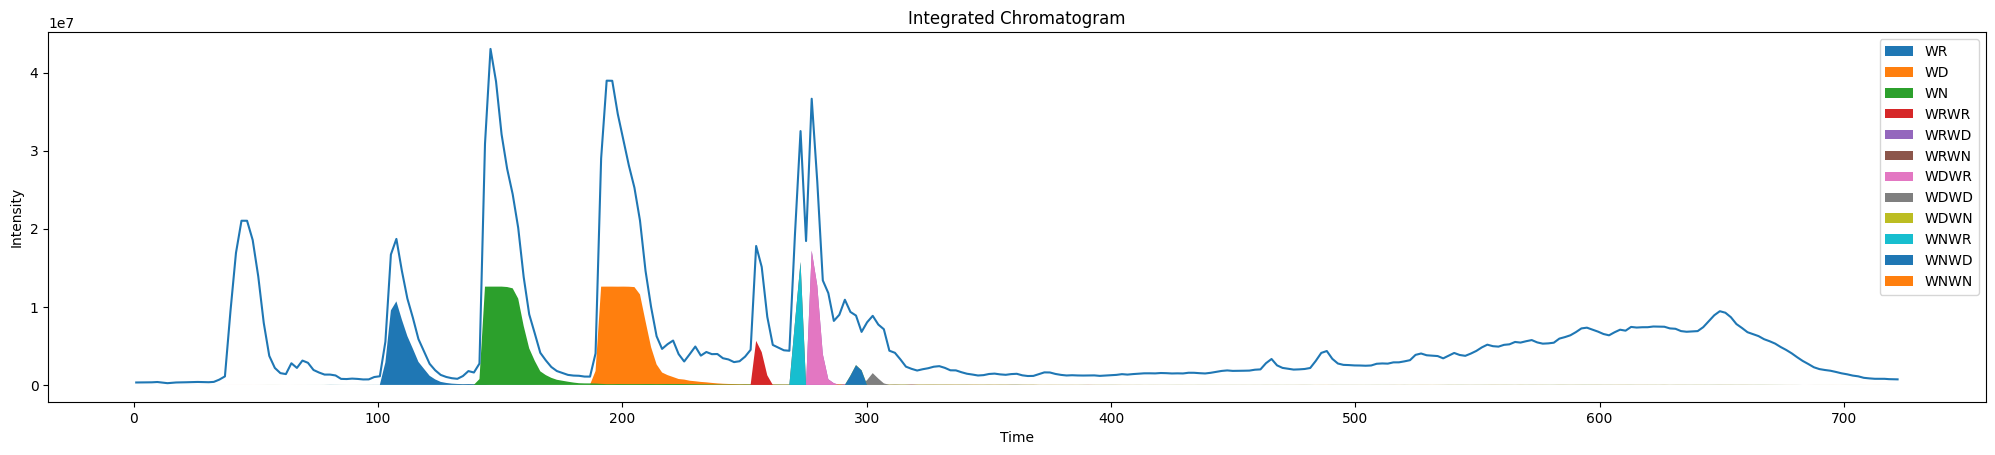

In [7]:
  
# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.mzXML'):
        file_path = os.path.join(directory, filename)
        print(f"Processing file: {file_path}")
        if os.path.exists(file_path):
            process_file(file_path)

            # Create the output file name
            output_file_name = f"{os.path.splitext(filename)[0]}_output.csv"
            
        else:
            print(f"File not found: {file_path}")